In [7]:
import os
import time
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from pandas_datareader import data as pdr

# 1. Download data 
Use yahoo finance to download data from a list of assets.

In [8]:
yf.pdr_override()
# Download data
def DownloadData(assets, path_to_folder, start, end=None):
    '''
    Dowload data from yahoo finance
    assets: list of assets we want to download
    start: start date of of the time series
    end: end date of the time series
    '''
    
    if end == None:
        end = datetime.now().strftime("%Y-%m-%d")
    else:
        end = end
        
    # Download data
    df = pd.DataFrame()

    for asset in assets:
        df_asset = pdr.get_data_yahoo(asset, start, end)
        # df = pd.concat([df_asset, df], axis=1, sort=False)
        df_asset = df_asset.reset_index(drop = False)
        if not os.path.exists(path_to_folder):
            os.makedirs(path_to_folder)
        df_asset.to_csv(path_to_folder + '/' + str(asset) + '.csv', index = False)
    
#     print(df_asset.head)
#     start = datetime.strptime(start, '%Y-%m-%d')
#     end = datetime.strptime(end, '%Y-%m-%d')
    
#     Dates = list()
#     delta = end - start   
#     f = open('TradingDates.txt','w')
#     for i in range(delta.days + 1):
#         day = start + timedelta(days=i)
#         f.write(day.strftime("%Y-%m-%d")+'\n')
#         Dates.append(day.strftime("%Y-%m-%d"))
#     print(len(Dates))
#     return Dates

In [9]:
assets = ['SAN.MC', 'TEF.MC', 'GRF.MC', 'BIO.MC', 'FAE.MC', 'AIR.MC', 'IDR.MC', 'ITX.MC', 'SLR.MC']
start = '2020-01-01'
end = '2020-07-11'
path_to_folder = r'Madrid_SE_' + start + '_' + end 
DownloadData(assets, path_to_folder, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# 2. Pre-process data  

Here, the dataframes froms stock assets are process in order to get the input tensor to feed into the NN $X$, and the price relative vector $Y_t$ for the actual period, which informs about the changes on the asset prices.

* $X\_ON$ is a rank 3 tensor $[features, assets, periods (t-n:t)]$ 
For each stock, the input is a raw time series of the prices (High, Low, Open, Close). 
The output is a matrix of 4 rows and n (number of available data points) columns. 
The columns correspond to:
    - Close(t-1)/Open(t-1)
    - High(t-1)/Open(t-1)
    - Low(t-1)/Open(t-1)
    - Open(t)/Open(t-1)
    
* $X\_CN\_t$ is a rank 3 tensor $[features, assets, periods (t-n:t)]$ 
For each stock, the input is a raw time series of the prices (High, Low, Open, Close). 
The output is a matrix of 3 rows and n (number of available data points) columns. 
The columns correspond to:
    - Close(t-1)/Close(t)
    - High(t-1)/Close(t)
    - Low(t-1)/Close(t)


* Change in price:
    - $Y_O_t$ is a vector (rank 1 tensor) such that $Y_t = \frac{opening\_price_t}{opening\_price_{t-1}}=(\frac{opening\_price_{t,1}}{opening\_price_{t-1,1}},..., \frac{opening\_price_{t,m}}{opening\_price_{t-1},m})$ where $m$ is the total number of assets. $Y_t$ informs about the change of price of each of the assets during the actual session and therefore allows defining the change in total portfolio value.
    -$Y_C_t$ is a vector (rank 1 tensor) such that $Y_t = \frac{closing\_price_t}{opening\_price_t}=(\frac{closing\_price_{t,1}}{opening\_price_{t,1}},..., \frac{closing\_price_{t,m}}{opening\_price_{t},m})$ where $m$ is the total number of assets. $Y_t$ informs about the change of price of each of the assets during the actual session and therefore allows defining the change in total portfolio value.
    
<u>Remark:</u> We don't need to normalize the data since it's already of ratio of 2 prices closed to one. 


In [10]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [11]:
def PreProcess(path, path_to_save, assets = None, volume_selection = False, save = True, plot = False,
               plot_train = False, plot_val = False, plot_test = False, plot_all = True):
    '''
    Get tensors for training NN:
    :path: path where the csv are stored
    '''
    
    directory = os.getcwd() + path # path to the files
    files_tags = os.listdir(directory) #these are the differents pdf files
    
    # Read only csv
    def get_csv(files_tags):
        for file in files_tags:
            if file.endswith(".csv") == False:
                files_tags.remove(file)
        return files_tags
    
    asset_files = get_csv(files_tags)
    asset_names = [file.split('.')[0] for file in asset_files]

    # Select stocks to trade with:
    def select_assets(m):
        # Select the m top volumed stocks from market
        volume = []
        for asset in (asset_files):
            df = pd.read_csv(os.getcwd() + path + asset)
        # Define volume criteria
        
    # If a list of trading assets is provided it reads data from it, else it select data according to a criteria
    if assets != None:
        portfolio_assets = assets
    else:
        if volume_selection:
            m = None
            select_assets(m)
        else:
            portfolio_assets = asset_files
            
    # Get tensor 
    list_open = list()
    list_close = list()
    list_high = list()
    list_low = list()
    list_volume = list()
    list_dates= list()
    list_stocks = list()

    # There is a dataframe per asset
    for asset in portfolio_assets:
        data = pd.read_csv(os.getcwd() + path + asset + '.csv').fillna('bfill').copy()
        Dates = data.Date.to_list()
        data = data[['Date','Open', 'Close', 'High', 'Low', 'Volume']]
        # Each element of each list is an array with the feature prices of each asset
        list_open.append(data.Open.values)
        list_close.append(data.Close.values); list_dates.append(data.Date.values)#; print(len(data.Date))
        list_high.append(data.High.values)
        list_low.append(data.Low.values)
        list_volume.append(data.Volume.values)
        list_stocks.append(asset)

        
        
    # Actually, they are matrices of shape (previous periods, assets)
    array_open = np.transpose(np.array(list_open))[:-1]            # Opening prices of each date except the current one
    array_open_of_the_day = np.transpose(np.array(list_open))[1:]  # Opening prices of each date except the first one
    array_close = np.transpose(np.array(list_close))[:-1]          # Closing prices of each date except the current one
    array_high = np.transpose(np.array(list_high))[:-1]            # Highest prices of each date except the current one
    array_low = np.transpose(np.array(list_low))[:-1]              # Lowest prices of each date except the current one
    array_volume = np.transpose(np.array(list_volume))[:-1]
    array_stocks = np.array(list_stocks)
 
    # TODO: print date ticks
    
    if plot:
        dates = [datetime.strptime(d,"%Y-%m-%d").date() for d in Dates]
        dates = dates[:-1] # Because when computing relative prices we leave the last date out
        fig, ax = plt.subplots()        
        if plot_train:
            start = 0; end = int(0.6 * len(dates)); string = 'train set'
        elif plot_val:
            start = int(0.6 * len(dates)); end = int(0.8 * len(dates)); string = 'validation set'
        elif plot_test:
            start = int(0.8 * len(dates)); end = len(dates); string = 'test set'
        elif plot_all:
            start = 0; end = len(dates); string = 'complete trading period'
        for i in range(len(list_stocks)):
            ax.plot(dates[start:end], array_close[start:end,i], label = 'Closing price of asset {}'.format(list_stocks[i]))
        plt.title('Asset evolution over ' + string)
        plt.ylabel("Price evolution", fontsize=12)
        plt.xlabel("TimeStamps", fontsize=12)
        fig.autofmt_xdate()                              # Rotate and align the tick labels so they look better
        ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')  # Format dates to string for the x axis locations 
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

    # Input tensor of the NN (normalized by its openin price at each season)
#     X = np.transpose(np.array([array_close/array_open, 
#                               array_high/array_open,
#                               array_low/array_open,
#                               array_open_of_the_day/array_open]), axes= (0,2,1))
# #     X.shape [features, assets, periods]
#     if save:
#         np.save(path_to_save, X)
    
    # Input tensor of the NN (normalized by its closing price of actual period t)
    closing_t = np.transpose(np.array(list_close))[-1:]
    X_CN_t = np.transpose(np.array([array_close/closing_t, 
                                   array_high/closing_t,
                                   array_low/closing_t, 
                                   array_open_of_the_day/array_open]), axes= (0,2,1))
    # X.shape [features, assets, periods]
    if save:
        np.save(path_to_save, X_CN_t)

    return list_dates

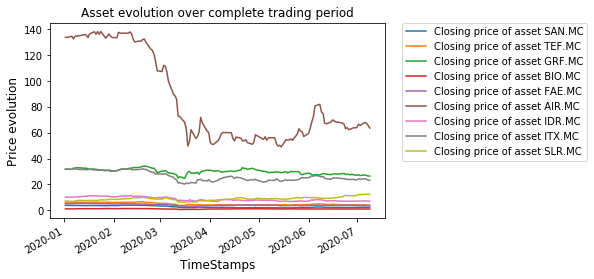

In [13]:

path_to_read = '/' + path_to_folder + '/' #'./Madrid_SE_2014-01-01_2020-01-01/'
path_to_save = './np_data/input_' + start + '_' + end + '_closeNorm.npy'
a = PreProcess(path_to_read, path_to_save, assets, save = True, plot = True,
               plot_train = False, plot_val = False, plot_test = False, plot_all = True)

